In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
import copy

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.models as models

In [5]:
device = torch.device("cuda")

## Image to Tensor Conversions

In [57]:
imsize = 1024

def file_to_tensor(file_path):
    image = Image.open(file_path)
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def image_to_tensor(image):
    ten_image = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])(image).to(device)
    ten_image.unsqueeze_(0) # adds batch size = 1
    return ten_image

def tensor_to_image(tensor):
    img = transforms.ToPILImage()(tensor.clone().cpu().squeeze(0))
    return img

In [58]:
set_folder = "Set11"

content = file_to_tensor("UpdatedSets/"+set_folder+"/content.jpg")
style = file_to_tensor("UpdatedSets/"+set_folder+"/style.png")

In [59]:
if content.size() != style.size():
    print("Please execute Processing the Data.ipynb on the dataset")

## Choosing the optimal model

In [24]:
vgg = models.vgg19_bn(pretrained=True).features.to(device).eval()

# Setting Up the Normalisation Layer for VGG

In [10]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(-1,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(-1,1,1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

# Setting Up the Content Loss - Simple MSE Loss

In [11]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(img, self.target)
        return img

# Setting Up the Style Loss - Using Gram Matrix

In [12]:
def convert_to_gram(img):
    b, f, h, w = img.size()
    reshp_img = img.view(b*f, w*h)
    gram = torch.mm(reshp_img, reshp_img.t()).div(b*f*w*h)
    return gram

In [13]:
class StyleLoss(nn.Module):
    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = convert_to_gram(target).detach()
    
    def forward(self, img):
        self.loss = F.mse_loss(convert_to_gram(img), self.target)
        return img

# Create the new model

In [25]:
content_layers = ['conv_2', 'conv_5']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_7']


def get_new_model(vgg19, content_image, style_image):
    
    global content_layers
    global style_layers
    content_modules = []
    style_modules = []

    vgg = copy.deepcopy(vgg19)
    normalisation = Normalization().to(device)
    model = nn.Sequential(normalisation)
    i = 0

    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_'+str(i)

        elif isinstance(layer, nn.ReLU):
            name = 'relu_'+str(i)

        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_'+str(i)

        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_'+str(i)

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_l = ContentLoss(target)
            model.add_module('content_layer_'+str(i), content_l)
            content_modules.append(content_l)
        
        if name in style_layers:
            target = model(style_image).detach()
            style_l = StyleLoss(target)
            model.add_module('style_layer_'+str(i), style_l)
            style_modules.append(style_l)
        
    for i in range(len(model)-1, 0, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:i+1]
    return model, content_modules, style_modules

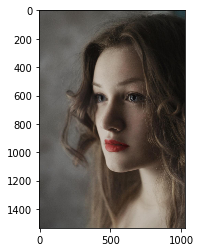

In [69]:
use_content = True
input_img = None

if use_content is True:
    # For using the content image
    input_img = tensor_to_image(content)
else:
    # For using random noise as input
    input_img = tensor_to_image(torch.randn(content.data.size(), device=device))

plt.imshow(input_img)

# Training the model

In [67]:
def style_transfer(vgg, content_img, style_img, input_img, iters=10, style_w=1000000, content_w=1):
    
    input_img = image_to_tensor(input_img)
    model, con_layers, st_layers = get_new_model(vgg, content_img, style_img)
    optimiser = torch.optim.LBFGS([input_img.requires_grad_()], lr=0.05)
    
    for i in range(iters):
        
        def closure():
            input_img.data.clamp_(0, 1)
            model(input_img)
            style_val = 0
            content_val = 0
            
            optimiser.zero_grad()

            for sc in st_layers:
                style_val += sc.loss
            for cc in con_layers:
                content_val += cc.loss

            net_loss = style_w*style_val + content_w*content_val
            net_loss.backward()
            print('Iteration {}: '.format(i+1), 'Style Loss = {:4f} '.format(style_val),
              'Content Loss = {:4f} '.format(content_val))
            return net_loss
            
        optimiser.step(closure)

    input_img.data.clamp_(0, 1)
    final_img = tensor_to_image(input_img)
    plt.imshow(final_img)
    return final_img

Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000000 
Iteration 1:  Style Loss = 0.000016  Content Loss = 0.000368 
Iteration 1:  Style Loss = 0.000015  Content Loss = 0.005087 
Iteration 1:  Style Loss = 0.000013  Content Loss = 0.018659 
Iteration 1:  Style Loss = 0.000012  Content Loss = 0.039099 
Iteration 1:  Style Loss = 0.000011  Content Loss = 0.058233 
Iteration 1:  Style Loss = 0.000010  Content Loss = 0.075710 
Iteration 1:  Style Loss = 0.000009  Content Loss = 0.091197 
Iteration 1:  Style Loss = 0.000008  Content Loss = 0.104500 
Iteration 1:  Style Loss = 0.000008  Content Loss = 0.116507 
Iteration 1:  Style Loss = 0.000007  Content Loss = 0.127134 
Iteration 1:  Style Loss = 0.000007  Content Loss = 0.136594 
Iteration 1:  Style Loss = 0.000006  Content Loss = 0.144977 
Iteration 1:  Style Loss = 0.000006  Content Loss = 0.152550 
Iteratio

Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196516 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196514 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196507 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196494 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196477 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196455 
Iteration 7:  Style Loss = 0.000000  Content Loss = 0.196429 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196399 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196365 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196327 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196286 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196241 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196194 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196144 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196090 
Iteration 8:  Style Loss = 0.000000  Content Loss = 0.196035 
Iteratio

Iteration 14:  Style Loss = 0.000000  Content Loss = 0.191287 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.191164 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.191037 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190905 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190769 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190629 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190485 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190340 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190192 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.190045 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.189897 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.189750 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.189604 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.189460 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.189316 
Iteration 14:  Style Loss = 0.000000  Content Loss = 0.

Iteration 20:  Style Loss = 0.000000  Content Loss = 0.183981 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.183914 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.183847 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.183779 
Iteration 20:  Style Loss = 0.000000  Content Loss = 0.183712 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183644 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183577 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183510 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183443 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183378 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183313 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183249 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183186 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183124 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.183064 
Iteration 21:  Style Loss = 0.000000  Content Loss = 0.

Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177784 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177738 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177694 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177652 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177612 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177574 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177538 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177504 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177471 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177441 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177412 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177386 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177361 
Iteration 27:  Style Loss = 0.000000  Content Loss = 0.177338 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.177316 
Iteration 28:  Style Loss = 0.000000  Content Loss = 0.

Iteration 33:  Style Loss = 0.000000  Content Loss = 0.174976 
Iteration 33:  Style Loss = 0.000000  Content Loss = 0.174982 
Iteration 33:  Style Loss = 0.000000  Content Loss = 0.174989 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.174995 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175001 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175007 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175012 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175017 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175022 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175026 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175029 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175031 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175033 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175033 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.175033 
Iteration 34:  Style Loss = 0.000000  Content Loss = 0.

Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171180 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171161 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171141 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171120 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171098 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171075 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171051 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171026 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.171000 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.170973 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.170945 
Iteration 40:  Style Loss = 0.000000  Content Loss = 0.170915 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.170885 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.170854 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.170821 
Iteration 41:  Style Loss = 0.000000  Content Loss = 0.

Iteration 46:  Style Loss = 0.000000  Content Loss = 0.167127 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167092 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167056 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.167020 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166983 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166946 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166908 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166870 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166833 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166795 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166757 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166719 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166681 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166643 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.166604 
Iteration 47:  Style Loss = 0.000000  Content Loss = 0.

Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164198 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164179 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164159 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164139 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164119 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164098 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164076 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164054 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164031 
Iteration 53:  Style Loss = 0.000000  Content Loss = 0.164008 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.163984 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.163960 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.163935 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.163910 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.163884 
Iteration 54:  Style Loss = 0.000000  Content Loss = 0.

Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161947 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161930 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161913 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161895 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161878 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161860 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161843 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161825 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161808 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161791 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161774 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161757 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161740 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161724 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.161708 
Iteration 60:  Style Loss = 0.000000  Content Loss = 0.

Iteration 66:  Style Loss = 0.000000  Content Loss = 0.160922 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.160908 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.160894 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.160881 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.160868 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.160855 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.160842 
Iteration 66:  Style Loss = 0.000000  Content Loss = 0.160829 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160817 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160805 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160793 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160782 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160771 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160761 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.160751 
Iteration 67:  Style Loss = 0.000000  Content Loss = 0.

Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159830 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159816 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159804 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159792 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159781 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159770 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159760 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159751 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159742 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159735 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159728 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159721 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159715 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159710 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.159706 
Iteration 73:  Style Loss = 0.000000  Content Loss = 0.

Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158892 
Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158890 
Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158888 
Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158887 
Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158886 
Iteration 79:  Style Loss = 0.000000  Content Loss = 0.158886 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158885 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158886 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158886 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158887 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158888 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158889 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158890 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158891 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.158893 
Iteration 80:  Style Loss = 0.000000  Content Loss = 0.

Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157738 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157738 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157739 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157739 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157739 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157740 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157740 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157740 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157741 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157741 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157741 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157741 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157741 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157740 
Iteration 86:  Style Loss = 0.000000  Content Loss = 0.157739 
Iteration 87:  Style Loss = 0.000000  Content Loss = 0.

Iteration 92:  Style Loss = 0.000000  Content Loss = 0.157003 
Iteration 92:  Style Loss = 0.000000  Content Loss = 0.157004 
Iteration 92:  Style Loss = 0.000000  Content Loss = 0.157005 
Iteration 92:  Style Loss = 0.000000  Content Loss = 0.157005 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157005 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157004 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157003 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.157001 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.156999 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.156996 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.156993 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.156989 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.156985 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.156980 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.156975 
Iteration 93:  Style Loss = 0.000000  Content Loss = 0.

Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156203 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156197 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156190 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156183 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156175 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156167 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156159 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156150 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156141 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156131 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156121 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156110 
Iteration 99:  Style Loss = 0.000000  Content Loss = 0.156099 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.156088 
Iteration 100:  Style Loss = 0.000000  Content Loss = 0.156076 
Iteration 100:  Style Loss = 0.000000  Content Loss =

Iteration 105:  Style Loss = 0.000000  Content Loss = 0.155522 
Iteration 105:  Style Loss = 0.000000  Content Loss = 0.155512 
Iteration 105:  Style Loss = 0.000000  Content Loss = 0.155500 
Iteration 105:  Style Loss = 0.000000  Content Loss = 0.155488 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155477 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155464 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155452 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155440 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155427 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155414 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155401 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155388 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155376 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155363 
Iteration 106:  Style Loss = 0.000000  Content Loss = 0.155350 
Iteration 106:  Style Loss = 0.000000  C

Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155381 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155371 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155362 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155354 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155345 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155337 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155329 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155320 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155312 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155305 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155298 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155291 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155285 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155279 
Iteration 112:  Style Loss = 0.000000  Content Loss = 0.155273 
Iteration 113:  Style Loss = 0.000000  C

Iteration 118:  Style Loss = 0.000000  Content Loss = 0.154993 
Iteration 118:  Style Loss = 0.000000  Content Loss = 0.154981 
Iteration 118:  Style Loss = 0.000000  Content Loss = 0.154969 
Iteration 118:  Style Loss = 0.000000  Content Loss = 0.154959 
Iteration 118:  Style Loss = 0.000000  Content Loss = 0.154950 
Iteration 118:  Style Loss = 0.000000  Content Loss = 0.154941 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.154934 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.154927 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.154922 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.154917 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.154913 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.154911 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.154909 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.154908 
Iteration 119:  Style Loss = 0.000000  Content Loss = 0.154908 
Iteration 119:  Style Loss = 0.000000  C

Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154517 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154525 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154534 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154544 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154554 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154565 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154576 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154588 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154600 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154612 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154625 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154638 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154652 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154665 
Iteration 125:  Style Loss = 0.000000  Content Loss = 0.154678 
Iteration 125:  Style Loss = 0.000000  C

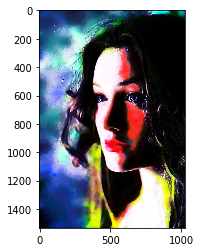

In [70]:
output = style_transfer(vgg, content, style, input_img, iters=130, style_w=50000000, content_w=10)
output.save("UpdatedSets/"+set_folder+"/output_large3.png")